In [1]:
from DELCgen import *
import scipy.stats as st
import matplotlib.pyplot as plt 
from constants import *
from scipy.interpolate import interp1d
import naima
import astropy.units as u
import subroutines as sub
import os
import simulation as sim

This piece of code runs a simple simulation where a CR population is injected and evolved with a variable jet. We need to define the maximum rigidity which is related to the jet power
$$
R_{\mathrm{max}} = 10^{19}~V\left(\frac{Q_j}{10^{44}~\mathrm{erg~s}^{-1}}\right)^{1/2}
    \left(\frac{\eta}{0.1}\right)
    \left(\frac{u}{0.1c}\right).
$$

the "power threshold" is the inverse expression with $Q_j$ as the subject. We use an input power spectral density (PSD) and jet power probability distribution function (PDF) to generate a time series for the jet power for a given set of PSD and PDF parameters. To do this, we use the method described by Emmanolopoulous et al. and implemented in python by Connolly. The PSD is implemented as a bending power-law model of the form 

$$\mathrm{PSD}(\nu,\bar{Q},\nu_c) = A(\bar{Q}) \frac{\nu^{-\alpha_{\mathrm{low}}}}
               {1+(\nu/\nu_c)^{\alpha_{\mathrm{high}}-\alpha_{\mathrm{low}}}}$$
               
               
We set $\alpha_{\mathrm{low}} = 1$ for a pink noise spectrum, $\alpha_{\mathrm{high}} = 10$ so as to suppress high frequency variability, and $\nu_c = 1$Myr, roughly equal to the light travel time, $\tau_c=L/c$, along a $L=300$kpc jet. The acceleration time relates to $\tau_c$ by $\tau_\mathrm{acc}/\tau_c \approx (Rc)/(uL)$, since the highest energy particles reach Larmor radii comparable to $(u/c)R$ (Hillas criterion). The longest CR acceleration time is therefore shorter than the light travel time along the jet for any fast, long and thin jet ($u/c>R/L$). 

In [2]:
def get_lc(lognorm_params, PSD_params, tbin, Age):
    # Simulation params
    # let's do everything in units of kyr
    # run for 100 Myr (1e5 kyr) in bins of 0.1 Myr
    #lognorm_params = (1.5,0,np.exp(1.5))
    RedNoiseL,RandomSeed,aliasTbin = 100,15,100
    N = Age / tbin

    lc = Simulate_DE_Lightcurve(BendingPL, PSD_params,st.lognorm,lognorm_params,
                                    RedNoiseL=RedNoiseL,aliasTbin=aliasTbin,randomSeed=RandomSeed,LClength=Age, tbin=tbin)

    return (lc)

Now we've set up the basic functions. Let's initialise our parameters for the variable jet history and initialise the tau_loss dictionary which stores the loss times for the different species (calculated using CRPropa).  

In [3]:
# since we're in Kyr units, set up conversion
MYR = 1e3

# set up light curve. pl_index of 1 means red noise.
pl_index = 1

# bend the power law at 1 Myr (1e-3 kyr^-1) and steeply decay it beyond that with index 10. 
# A,v_bend,a_low,a_high,c = 1, 1e-3, pl_index, 10, 1
PSD_params = (1, 1.0 * MYR, pl_index, 20, 0)
tbin = 0.1 * MYR   # 100 kyr 
Age = 400.0 * MYR
Length = int(Age / tbin)

# time is in kyr, so convert to Myr
times = np.arange ( 0, Length*tbin, tbin) 

elems = ["H", "He", "N", "Fe"]
tau_loss = dict()
energies = np.logspace(6,20.5,num=3000)
for i in range(len(elems)):
    tau_loss[elems[i]] = sub.Losses(elems[i])
    tau_loss[elems[i]].interpol(energies)
    
lognorm_params = (1.5,0,np.exp(1.5))
    
# paramaters for lc are lognorm parameters, PSD parameters, tbin and Length (Age is really number of points)
lc = get_lc(lognorm_params, PSD_params, tbin, Length)

Set up arrays to loop over. flux_scales contains the normalisations of our jet power $(\bar{Q})$.
This is actually the median of the distribution, or the mean in log space.
betas is the spectral index of the injected spectrum ($\beta$).

In [4]:
# flux_scales contains the normalisations of our jet power 
# actually the median of the distribution, or the mean in log space.
# betas is the spectral index of the injected spectrum 
flux_scales = np.logspace(43,45,num=10)
betas = np.arange(2,3,0.1)
betas = [2,2.3,2.7]
flux_scales = np.logspace(42.5,44.5,num=10)
#flux_scales = [1e43]
#betas = [2]
#sigmas = [0.5]
print (flux_scales)
sigmas = np.linspace(0.5,3,num=4)

# arrays to store gamma ray and UHECR luminosities
lgammas = np.zeros((len(sigmas), len(flux_scales), len(betas)))
lcrs = np.zeros((len(sigmas), len(flux_scales), len(betas)))
print (energies)

[3.16227766e+42 5.27499706e+42 8.79922544e+42 1.46779927e+43
 2.44843675e+43 4.08423865e+43 6.81292069e+43 1.13646367e+44
 1.89573565e+44 3.16227766e+44]
[1.00000000e+06 1.01119507e+06 1.02251548e+06 ... 3.09264528e+20
 3.12726767e+20 3.16227766e+20]


Let's loop over the flux scales and the spectral indices. The method is as follows. For each value of $\bar{Q}$ and $\beta$, we evolve a CR distribution for each ionic species numerically using the following equation,

$$
    \frac{dn_i(E)}{dt} = S(E/Z_i, f_i, t) - \frac{n(E)}{\tau_\mathrm{esc} (E/Z_i)} - \frac{n(E)}{\tau_\mathrm{loss} (E, Z_i)}.
$$

The total differential CR spectrum is then just $n(E,t)=\sum_i n_i(E,t)f_i$. We follow, e.g., Eichmann et al. 2018 in using a power-law for the injection term $S({\cal R}_i, f_i, t)$ with a sharp cutoff, given by

$$
    S(E/Z_i, f_i, t) = 
    f_i \eta Q_j(t)~\nu_i
    \left(\frac{{\cal R}}{{\cal R}_0}\right)^{-\beta}~f_{\mathrm{cut}}(R_{\mathrm{max}}).
    % f_\mathrm{cut}
$$

where $\nu_i$ is the normalisation of the distribution and is given by $\nu_i=1.0/[\ln({\cal R}_\mathrm{max}(t)/{\cal R}_0]$ for $\beta=2$ and $\nu_i=(2-\beta)/[({\cal R}_\mathrm{max}/{\cal R}_0)^{(2-\beta)}-1]$ for $\beta > 2$.  We set ${\cal R}_\mathrm{max}$ according to the maximum rigidity condition, ${\cal R}_0=1\mathrm{GV}$. 

In [5]:
for i_sigma, SIGMA in enumerate(sigmas):
    
    lognorm_params = (SIGMA,0,np.exp(SIGMA))
    
    # paramaters for lc are lognorm parameters, PSD parameters, tbin and Length (Age is really number of points)
    lc = get_lc(lognorm_params, PSD_params, tbin, Length)
                      
    for i_flux, flux_scale in enumerate(flux_scales):

        # normalise the light curve
        flux = lc.flux * flux_scale 

        # loop over spectral indices
        for i_beta, BETA in enumerate(betas):

            # elemental "abundances" - really injection fractions 
            # this is roughly solar, but should probably be top heavy since it is easier to inject heavy ions, generally
            frac_elem = np.array([1.0,0.1,1e-4,3.16e-05])

            ncr, escaping, lcr = sim.run_jet_simulation(energies, flux_scale, BETA, lc, tau_loss,
                                                        frac_elem=frac_elem, plot_all=False, 
                                                        sigma=SIGMA, R0=1e9, NRES = 20, NMAX=8000)

            # get approximate gamma ray luminosity around 10 GeV
            select = (energies > 1e10) * (energies < 2e10)
            my_lgamma = np.fabs(np.trapz(energies[select] * EV2ERGS, energies[select]*ncr[0,-1,:][select]))

            # distance to Cen A
            distance = 3.7 * PARSEC * 1e6
            lgammas[i_sigma,i_flux,i_beta] = my_lgamma * 1e-4 * 4.5e-26 * 0.5 * C / 4.0 / PI / distance / distance
            
            select = (energies > 6e19)

            # store the UHECR luminosity 
#             lcr = np.fabs(np.trapz(energies[select] * EV2ERGS, energies[select] * escaping[select]))
            lcrs[i_sigma,i_flux,i_beta] = lcr
            lg = my_lgamma * 1e-4 * 4.5e-26 * 0.5 * C / 4.0 / PI / distance / distance
            
            print ("sigma {:.1f} BETA {:.1f} median lum {:8.4e} mean lum {:8.4e} UHECR LUM: {:8.4e} {:8.4e}"
                   .format(SIGMA, BETA, flux_scale, np.mean(flux), lcr, lg))
                   


4000


/Users/matthews/cr/CR-Variable-Jet/simulation.py:439: RuntimeWarning: invalid value encountered in arccos
  w = L / np.pi * np.arccos(np.sqrt(z/L))
/Users/matthews/cr/CR-Variable-Jet/simulation.py:392: RuntimeWarning: divide by zero encountered in true_divide
  theta = np.arctan(self.z/self.width)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:1068: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:1069: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:1075: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/Library/Frameworks/Python.framework/Versions/3.7

sigma 0.5 BETA 2.0 median lum 3.1623e+42 mean lum 5.8793e+42 UHECR LUM: 0.0000e+00 0.0000e+00
4000
sigma 0.5 BETA 2.3 median lum 3.1623e+42 mean lum 5.8793e+42 UHECR LUM: 0.0000e+00 0.0000e+00
4000
sigma 0.5 BETA 2.7 median lum 3.1623e+42 mean lum 5.8793e+42 UHECR LUM: 0.0000e+00 0.0000e+00
4000
sigma 0.5 BETA 2.0 median lum 5.2750e+42 mean lum 9.8073e+42 UHECR LUM: 0.0000e+00 0.0000e+00
4000
sigma 0.5 BETA 2.3 median lum 5.2750e+42 mean lum 9.8073e+42 UHECR LUM: 0.0000e+00 0.0000e+00
4000
sigma 0.5 BETA 2.7 median lum 5.2750e+42 mean lum 9.8073e+42 UHECR LUM: 0.0000e+00 0.0000e+00
4000
sigma 0.5 BETA 2.0 median lum 8.7992e+42 mean lum 1.6360e+43 UHECR LUM: 0.0000e+00 0.0000e+00
4000
sigma 0.5 BETA 2.3 median lum 8.7992e+42 mean lum 1.6360e+43 UHECR LUM: 0.0000e+00 0.0000e+00
4000
sigma 0.5 BETA 2.7 median lum 8.7992e+42 mean lum 1.6360e+43 UHECR LUM: 0.0000e+00 0.0000e+00
4000
sigma 0.5 BETA 2.0 median lum 1.4678e+43 mean lum 2.7289e+43 UHECR LUM: 0.0000e+00 0.0000e+00
4000
sigma 0.5 

sigma 2.2 BETA 2.7 median lum 1.1365e+44 mean lum 1.1637e+46 UHECR LUM: 0.0000e+00 0.0000e+00
4000
sigma 2.2 BETA 2.0 median lum 1.8957e+44 mean lum 1.9412e+46 UHECR LUM: 0.0000e+00 0.0000e+00
4000
sigma 2.2 BETA 2.3 median lum 1.8957e+44 mean lum 1.9412e+46 UHECR LUM: 0.0000e+00 0.0000e+00
4000
sigma 2.2 BETA 2.7 median lum 1.8957e+44 mean lum 1.9412e+46 UHECR LUM: 0.0000e+00 0.0000e+00
4000
sigma 2.2 BETA 2.0 median lum 3.1623e+44 mean lum 3.2381e+46 UHECR LUM: 0.0000e+00 0.0000e+00
4000
sigma 2.2 BETA 2.3 median lum 3.1623e+44 mean lum 3.2381e+46 UHECR LUM: 0.0000e+00 0.0000e+00
4000
sigma 2.2 BETA 2.7 median lum 3.1623e+44 mean lum 3.2381e+46 UHECR LUM: 0.0000e+00 0.0000e+00
4000
sigma 3.0 BETA 2.0 median lum 3.1623e+42 mean lum 6.9587e+45 UHECR LUM: 0.0000e+00 0.0000e+00
4000
sigma 3.0 BETA 2.3 median lum 3.1623e+42 mean lum 6.9587e+45 UHECR LUM: 0.0000e+00 0.0000e+00
4000
sigma 3.0 BETA 2.7 median lum 3.1623e+42 mean lum 6.9587e+45 UHECR LUM: 0.0000e+00 0.0000e+00
4000
sigma 3.0 

Now let's make a movie with ffmpeg (pretty hacky this)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


TypeError: Length of x must be number of columns in z.

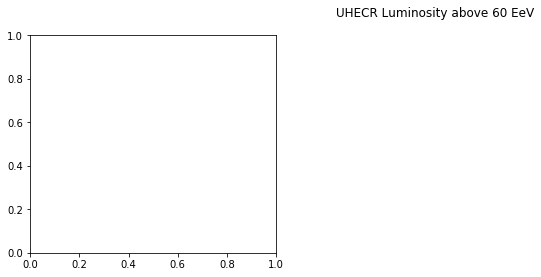

In [6]:

plt.figure(figsize=(15,4))
plt.suptitle("UHECR Luminosity above 60 EeV")
for i in range(len(betas)):
    plt.subplot(1,3,i+1)
    plt.contourf(sigmas, np.log10(flux_scales), np.log10(lcrs[:,:,i]))
    plt.colorbar()
    plt.contour(sigmas, np.log10(flux_scales), np.log10(lcrs[:,:,i]), levels=(39,), colors=("C3",), linewidths=3)
    plt.title(r"$\beta={:.1f}$".format(betas[i]), fontsize=16)
    plt.xlabel("$\sigma$", fontsize=16)
    if i == 0: 
        plt.ylabel("$\log Q$", fontsize=16)
    #plt.colorbar()
#plt.pcolormesh(sigmas, flux_scales, lcrs[:,:,1])

In [ ]:
plt.figure(figsize=(15,4))
plt.suptitle("Gamma-ray luminosity at 10 GeV")
for i in range(len(betas)):
    plt.subplot(1,3,i+1)
    plt.contourf(sigmas, np.log10(flux_scales), np.log10(lgammas[:,:,i]))
    plt.colorbar()
    plt.contour(sigmas, np.log10(flux_scales), np.log10(lgammas[:,:,i]), colors=("C3",), levels=(-12,), linewidths=3)
    plt.title(r"$\beta={:.1f}$".format(betas[i]), fontsize=16)
    plt.xlabel("$\sigma$", fontsize=16)
    if i == 0: 
        plt.ylabel("$\log Q$", fontsize=16)